<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#TODOs" data-toc-modified-id="TODOs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>TODOs</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

This notebook is from Winter 2022. 
It uses the court data we scraped in October 2021 to model cannabis policy in VA.

In [2]:
import os
import sys
sys.path.insert(0, os.path.relpath('../')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from super_simulation.super_simulation_factory import SuperSimulationFactory
from transition_table import TransitionTable
from shell_compartment import ShellCompartment
from spark_policy import SparkPolicy
from utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [3]:
crime_types = [
    'CONSPIRACY', 'DRUG_POSSESSION', 'DRUG_SALE', "DRUG_OTHER", "KIDNAPPING", "MANSLAUGHTER", "LARCENY", "WEAPON",
    "ASSAULT", "ROBBERY", "BURGLARY", "DWI", "RAPE", "SEX_OFFENSE", "ARSON", 'FIRST_DEGREE_MURDER',
    'SECOND_DEGREE_MURDER', 'OTHER_MURDER', 'CAPITAL_MURDER'
]

LOS_BY_CRIME = {
    'CONSPIRACY': 0.899,
    'DRUG_POSSESSION': 0.897,
    'MARIJUANA_POSSESSION': 0.897,
    'DRUG_SALE': 0.902,
    'DRUG_OTHER': 0.901,
    'KIDNAPPING': 0.913,
    'MANSLAUGHTER': 0.916,
    'LARCENY': 0.907,
    'WEAPON': 0.905,
    'ASSAULT': 0.912,
    'ROBBERY': 0.920,
    'BURGLARY': 0.917,
    'DWI': 0.893,
    'RAPE': 0.906,
    'SEX_OFFENSE': 0.90,
    'ARSON': 0.914,
    'FIRST_DEGREE_MURDER': 0.907,
    'SECOND_DEGREE_MURDER': 0.914,
    'OTHER_MURDER': 0.908,
    'CAPITAL_MURDER': 0.898
}


In [3]:
sdc_data = pd.concat([
    pd.read_csv(
        f'../state/VA/VA_data/VA_circuit_data/circuit_data_{i}.csv',
        index_col=0
    ) for i in range(8)
])

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_9151/110041657.py:1: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  sdc_data = pd.concat([
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_9151/110041657.py:1: DtypeWarning: Columns (18,24) have mixed types.Specify dtype option on import or set low_memory=False.
  sdc_data = pd.concat([


# Preprocessing

## TODOs
* can't just drop 0 length sentences
* separate out jail


In [4]:
sdc_data['MARIJUANA'] = sdc_data.Charge.apply(
    lambda x: any([i in x for i in [
        'MARIJUANA',
        'MARIJ',
    ]])
)

sdc_data.MARIJUANA.describe()

count     1071608
unique          2
top         False
freq      1037028
Name: MARIJUANA, dtype: object

In [5]:
# sdc_data.head()
# sdc_data['DRUG_SALE'].mean()
# sdc_data['DRUG_POSSESSION'].mean()
# sdc_data['DRUG_OTHER'].mean()
# sdc_data.mean()

In [66]:
# We're currently missing a bunch of data that doesn't fall into any category, so we need to scale up counts 
# by the ratio of actual total data to the data we're catching

# https://vsp.virginia.gov/wp-content/uploads/2021/08/Crime_In_Virginia_2019.pdf
marijuana_arrests = 26470
total_arrests = 275903
b = marijuana_arrests / total_arrests  # true ratio of marijuana arrests out of total
a = len(sdc_data[sdc_data['MARIJUANA']]) / len(sdc_data)  # portion flagged as cannabis crimes
marijuana_scale = b / a  # Scale everything from current ratio to true ratio
print(a)  # 
print(b)  # 
print(marijuana_scale)  # 


scale_factor = len(sdc_data) / len(sdc_data[sdc_data.crime_type.notnull()])
sorted_data = sdc_data[sdc_data.crime_type.notnull()]
sorted_data.loc[sorted_data['MARIJUANA'] & sorted_data['DRUG_POSSESSION'], 'crime_type'] = 'MARIJUANA_POSSESSION'

# Calculate LOS using our percentage served data
sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)

# Drop sentences that will round to 0
sorted_data = sorted_data[sorted_data.LOS > 0.5]

# Calculate time_step column
sorted_data['time_step'] = (sorted_data.year - 2019) * 12 + sorted_data.month

# Create outflows table
outflows_data = sorted_data.groupby(['time_step', 'crime_type']).count()[['Address']].reset_index().rename(
    {'Address': 'total_population'}, axis=1
)
outflows_data['compartment'] = 'pretrial'
outflows_data['outflow_to'] = 'prison'
outflows_data.total_population *= scale_factor

# Fix the loc! Run it all, make sure numbers look reasonable
for time_step in range(-107, 34):
#     print(outflows_data.loc[(outflows_data['crime_type'] == 'DRUG_POSSESSION') & (outflows_data['time_step'] == time_step),
#                         'total_population'])
    outflows_data.loc[(outflows_data['crime_type'] == 'DRUG_POSSESSION') & (outflows_data['time_step'] == time_step),
                        'total_population'] -= float(((marijuana_scale - 1) * (outflows_data.loc[
                        (outflows_data['crime_type'] == 'MARIJUANA_POSSESSION') & (outflows_data['time_step'] == time_step),
                        'total_population'])))
#     print(outflows_data.loc[(outflows_data['crime_type'] == 'DRUG_POSSESSION') & (outflows_data['time_step'] == time_step),
#                         'total_population'])
    outflows_data.loc[(outflows_data['crime_type'] == 'MARIJUANA_POSSESSION') & (outflows_data['time_step'] == time_step),
                        'total_population'] *= marijuana_scale
outflows_data = outflows_data[(outflows_data['time_step'] > -108) & (outflows_data['time_step'] <= 33)]
outflows_data.time_step = outflows_data.time_step.astype('int64')
# print(outflows_data[''])
outflows_data.total_population = outflows_data.total_population.astype(float)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(outflows_data)

0.03226926264081642
0.09593951497446566
2.973092879200613


/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-66-21160a96853d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)


      time_step            crime_type  total_population compartment outflow_to
5178       -107                 ARSON            14.985    pretrial     prison
5179       -107               ASSAULT           304.703    pretrial     prison
5180       -107              BURGLARY           141.529    pretrial     prison
5181       -107            CONSPIRACY            31.636    pretrial     prison
5182       -107            DRUG_OTHER            86.582    pretrial     prison
5183       -107       DRUG_POSSESSION           147.689    pretrial     prison
5184       -107             DRUG_SALE           238.101    pretrial     prison
5185       -107                   DWI           171.499    pretrial     prison
5186       -107   FIRST_DEGREE_MURDER             3.330    pretrial     prison
5187       -107            KIDNAPPING             8.325    pretrial     prison
5188       -107               LARCENY           477.867    pretrial     prison
5189       -107          MANSLAUGHTER             6.

<AxesSubplot:xlabel='time_step'>

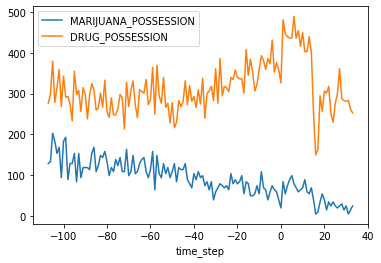

In [67]:
unstacked_outflows_data = outflows_data.groupby(['time_step', 'crime_type']).sum().iloc[:, 0].unstack('crime_type')
unstacked_outflows_data
display_df = pd.DataFrame()
display_df['MARIJUANA_POSSESSION'] = unstacked_outflows_data['MARIJUANA_POSSESSION']
display_df['DRUG_POSSESSION'] = unstacked_outflows_data['MARIJUANA_POSSESSION'] + unstacked_outflows_data['DRUG_POSSESSION']
display_df.plot()



<AxesSubplot:xlabel='time_step'>

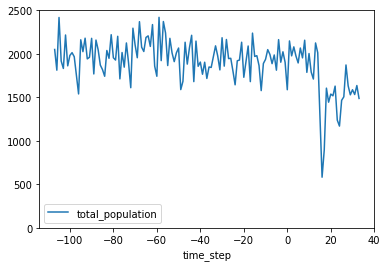

In [68]:
outflows_data.groupby('time_step').sum().plot(ylim=[0,2500])

In [69]:
# Create transitions datta
transitions_data = sorted_data.copy()
transitions_data['compartment_duration'] = transitions_data.LOS.round()
transitions_data = transitions_data.groupby([
    'compartment_duration', 'crime_type'
]).count()[['Address']].reset_index().rename({'Address': 'total_population'}, axis=1)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'

# add release transitions as well

crime_types.append('MARIJUANA_POSSESSION')

# taken from here (https://vadoc.virginia.gov/media/1681/vadoc-recidivism-re-arrest-rates-report-2016.pdf)
RECIDIVISM_BY_CRIME_TYPE = {
    'ARSON': 0.203,
    'ASSAULT': 0.246,
    'BURGLARY': 0.296,
    'CAPITAL_MURDER': 0.073,
    'CONSPIRACY': 0.263,
    'DRUG_OTHER': 0.212,
    'DRUG_POSSESSION': 0.239,
    'DRUG_SALE': 0.193,
    'DWI': 0.184,
    'FIRST_DEGREE_MURDER': 0.073,
    'KIDNAPPING': 0.146,
    'LARCENY': 0.284,
    'MARIJUANA_POSSESSION': 0.239,  # made same as DRUG_POSSESSION
    'MANSLAUGHTER': 0.105,
    'OTHER_MURDER': 0.073,
    'RAPE': 0.226,
    'ROBBERY': 0.206,
    'SECOND_DEGREE_MURDER': 0.073,
    'SEX_OFFENSE': 0.25,        
    'WEAPON': 0.209
}

# taken from https://vadoc.virginia.gov/media/1680/vadoc-state-recidivism-report-2021-05.pdf
RECIDIVISM_BY_MONTHS_SINCE_RELEASE = {
    6: (1.1 + 1.3 + 1.5 + 1.3  + 1.3 + 1.2) / 6,
    12: (4.3 + 5 + 4.9 + 5 + 4.9 + 4.6) / 6,
    18: (9.6 + 10.1 + 9.9 + 10.1 + 9.8) / 5,
    24: (15.0 + 15.3 + 15.0 + 15.6) / 4,
    36: (22.4 + 23.4 + 23.1 + 23.9) / 4
}
recidivism_transitions = pd.DataFrame({
    'compartment': ['release'] * 36,
    'outflow_to': ['prison'] * 36,
    'compartment_duration': range(1, 37),
    'total_population': (
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[6] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[12] / 6] * 6 +
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[18] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[24] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[36] / 12] * 12
    )
})

for crime in crime_types:
    crime_recidivism = recidivism_transitions.copy()
    total_recidivism = sum(RECIDIVISM_BY_MONTHS_SINCE_RELEASE.values())
    crime_specific_total_recidivism = RECIDIVISM_BY_CRIME_TYPE[crime]
    crime_recidivism.total_population *= crime_specific_total_recidivism / total_recidivism
    crime_recidivism = crime_recidivism.append({
        'compartment_duration': 36,
        'total_population': 1 - crime_specific_total_recidivism,
        'compartment': 'release',
        'outflow_to': 'release_full',
    }, ignore_index=True)
    crime_recidivism['crime_type'] = crime
    
    transitions_data = transitions_data.append(crime_recidivism)
    
    # adjust outflows so we're not double counting recidivism
    outflows_data.loc[
        outflows_data.crime_type == crime, 'total_population'
    ] /= 1 + crime_specific_total_recidivism


transitions_data = transitions_data.append(pd.DataFrame({
    'compartment_duration': [24] * len(crime_types),
    'total_population': [1] * len(crime_types),
    'compartment': ['release_full'] * len(crime_types),
    'outflow_to': ['release_full'] * len(crime_types),
    'crime_type': crime_types,
}), ignore_index=True)

transitions_data.total_population = transitions_data.total_population.astype(float)
transitions_data.head()

,compartment_duration,crime_type,total_population,compartment,outflow_to
0,1.0,ARSON,142.0,prison,release
1,1.0,ASSAULT,6064.0,prison,release
2,1.0,BURGLARY,956.0,prison,release
3,1.0,CONSPIRACY,279.0,prison,release
4,1.0,DRUG_OTHER,1598.0,prison,release


In [70]:
# Total population data

total_pop = {
    2021: [23811, 23644, 23769, 23897, 23966, 24229, 24467, 24625, 24694, 24738],
    2020: [29223, 29208, 29136, 28595, 27871, 27294, 26749, 26190, 25659, 25156, 24731, 24235],
    2019: [29708, 29859, 29992, 30014, 30028, 29995, 30049, 29857, 29696, 29664, 29392, 29347]
    
}

total_population_data = pd.DataFrame({
    'time_step': range(34),  # said it had to start at -24 during baseline, previously was range(34)
    'total_population': total_pop[2019] + total_pop[2020] + total_pop[2021]
})
total_population_data['compartment'] = 'prison'
total_population_data.total_population = total_population_data.total_population.astype(float)


In [71]:
# REDUCE TO JUST DRUG POSSESSION CUZ THAT'S ALL WE CARE ABOUT

population_breakdown = transitions_data.copy()
population_breakdown['weighted_population'] = \
    population_breakdown.total_population * population_breakdown.compartment_duration
population_breakdown = population_breakdown.groupby('crime_type').sum()
population_breakdown = \
    population_breakdown.weighted_population / population_breakdown.weighted_population.sum()
drug_possession_fraction = \
    population_breakdown.loc['DRUG_POSSESSION'] + population_breakdown.loc['MARIJUANA_POSSESSION']
population_breakdown

crime_type
ARSON                   0.007127
ASSAULT                 0.133082
BURGLARY                0.070751
CAPITAL_MURDER          0.011269
CONSPIRACY              0.013673
DRUG_OTHER              0.032352
DRUG_POSSESSION         0.096687
DRUG_SALE               0.095418
DWI                     0.018545
FIRST_DEGREE_MURDER     0.029375
KIDNAPPING              0.015408
LARCENY                 0.124783
MANSLAUGHTER            0.004332
MARIJUANA_POSSESSION    0.006121
OTHER_MURDER            0.059767
RAPE                    0.106018
ROBBERY                 0.105442
SECOND_DEGREE_MURDER    0.006245
SEX_OFFENSE             0.008245
WEAPON                  0.055360
Name: weighted_population, dtype: float64

In [72]:
drug_possession_fraction

0.10280795768330274

In [73]:
transitions_data = transitions_data[(transitions_data.crime_type == 'MARIJUANA_POSSESSION') |
                                    (transitions_data.crime_type == 'DRUG_POSSESSION')]
outflows_data = outflows_data[(outflows_data.crime_type == 'MARIJUANA_POSSESSION') |
                                    (outflows_data.crime_type == 'DRUG_POSSESSION')]
total_population_data.total_population *= drug_possession_fraction

In [74]:
simulation_tag = "cannabis_non_retroactive_no_recidivism"

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
    total_population_data,
    '../state/VA/2022/policy_configurations/cannabis_second_pass.yaml',
)

# Modeling

In [88]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../state/VA/2022/policy_configurations/cannabis_second_pass.yaml'
)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1852: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


outflows_data returned 282 results
transitions_data returned 383 results
total_population_data returned 34 results


initialization time:  357.4615743160248


simulation_time:  114.32113480567932


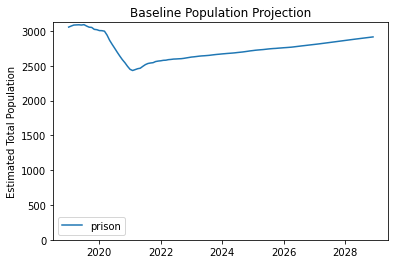

In [76]:
spark_sim.simulate_baseline(['prison'])

<AxesSubplot:xlabel='time_step'>

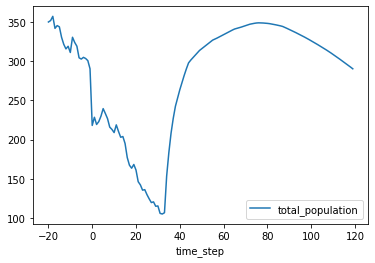

In [83]:
a = spark_sim.simulator.pop_simulations['baseline_projections'].population_projections
a[(a.compartment == 'prison') & (a.simulation_group == 'MARIJUANA_POSSESSION')].groupby('time_step').sum().loc[-20:].plot()

[<AxesSubplot:title={'center':'simulation_group: DRUG_POSSESSION\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: MARIJUANA_POSSESSION\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

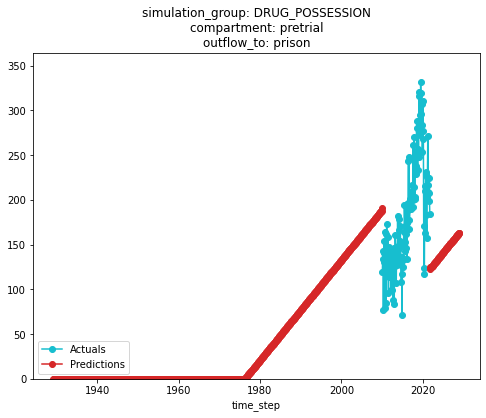

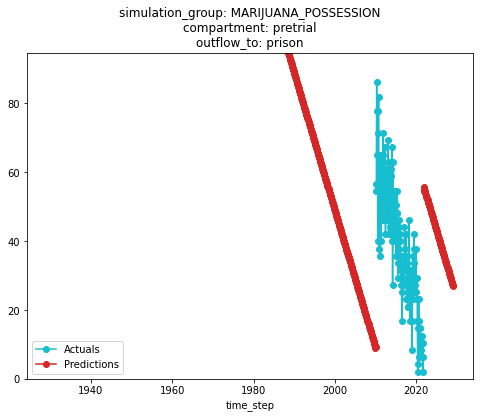

In [81]:
spark_sim.get_arima_output_plots('baseline_projections', by_simulation_group=True)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


initialization time:  16.54278802871704
initialization time:  16.94523811340332
simulation_time:  11.793198108673096


simulation_time:  11.818168878555298


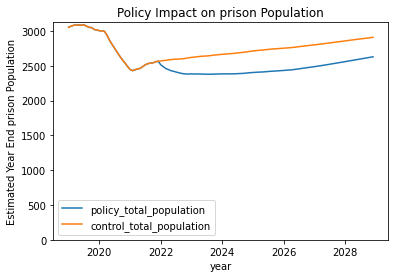

In [89]:
LOS_REDUCTION = 0.99999  #  Assuming it takes away whole sentence (0 length sentences confuse it)
AFFECTED_FRACTION = 1  # Releasing all w/o violent offense -- all under "MARIJUANA_POSSESSION" label?
REDUCTION_TYPE = '*'
OUTFLOW = 'release'
# RETROACTIVE = True


def reduce_cannabis_sentence(crime):
        return partial(ShellCompartment.reallocate_outflow, 
                    reallocation_fraction=1,
                    outflow = 'prison')        

def retroactive_cannabis(crime, RETROACTIVE):
        return partial(TransitionTable.apply_reduction, 
                   reduction_df=pd.DataFrame({
                       'outflow': [OUTFLOW],
                       'reduction_size': [LOS_REDUCTION], 
                       'affected_fraction': [AFFECTED_FRACTION]
                   }),
                   reduction_type=REDUCTION_TYPE,
                   retroactive=RETROACTIVE) 

policy_list = []
# policy_list.append(SparkPolicy(policy_fn=retroactive_cannabis('MARIJUANA_POSSESSION', True),
#                                            spark_compartment='prison',
#                                            sub_population={'crime_type': 'MARIJUANA_POSSESSION'},
#                                            policy_ts=36,
#                                            apply_retroactive=True))

policy_list.append(SparkPolicy(policy_fn=reduce_cannabis_sentence('MARIJUANA_POSSESSION'),
                                           spark_compartment='pretrial',
                                           sub_population={'crime_type': 'MARIJUANA_POSSESSION'},
                                           policy_ts=36,
                                           apply_retroactive=False))
    
test_results = spark_sim.simulate_policy(policy_list, 'prison')


In [115]:
admissions_baseline = spark_sim.simulator.pop_simulations['policy'].sub_simulations[
    'MARIJUANA_POSSESSION'
].simulation_compartments['pretrial'].admissions_predictors[-9999]

admissions_baseline.get_time_step_estimate(99)
monthly_admissions = admissions_baseline.predictions_df.unstack('outflow_to').loc[36:96].cumsum()


,predictions
outflow_to,prison
time_step,
36,54.695373
37,109.351708
38,163.527254
39,217.444859
40,270.992104
41,324.225701
42,377.117041
43,429.680556


<AxesSubplot:xlabel='compartment_duration'>

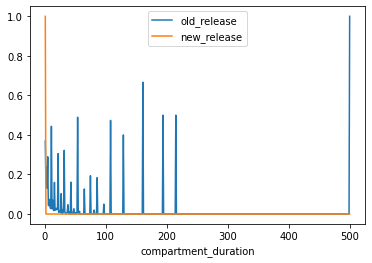

In [43]:
old_and_new_transitions = pd.DataFrame()
old_and_new_transitions['old_release'] = old_transitions['release']
old_and_new_transitions['new_release'] = new_transitions['release']
# [old_transitions['release'], new_transitions['release']]
old_and_new_transitions.plot()

In [44]:
transitions_baseline[-9999].unnormalize_table(-9999)

In [45]:
transitions_baseline[24].unnormalize_table(24)

<AxesSubplot:xlabel='compartment_duration'>

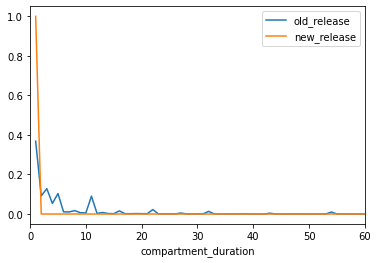

In [48]:
old_and_new_transitions = pd.DataFrame()
old_and_new_transitions['old_release'] = old_transitions['release']
old_and_new_transitions['new_release'] = new_transitions['release']
# [old_transitions['release'], new_transitions['release']]
old_and_new_transitions.plot(xlim=[0, 60])

In [ ]:
cohort_table = spark_sim.simulator.pop_simulations['policy'].sub_simulations[
    'MARIJUANA_POSSESSION'
].simulation_compartments['prison'].cohort_table

print(cohort)

In [90]:
simulation_tag = 'cannabis_non_retroactive_paco_feb_3_final_1'
spark_sim.upload_policy_simulation_results_to_bq(simulation_tag)

{'spending_diff':                       prison release release_full
 year                                             
 2019.000000              0.0     0.0          0.0
 2019.083333              0.0     0.0          0.0
 2019.166667              0.0     0.0          0.0
 2019.250000              0.0     0.0          0.0
 2019.333333              0.0     0.0          0.0
 2019.416667              0.0     0.0          0.0
 2019.500000              0.0     0.0          0.0
 2019.583333              0.0     0.0          0.0
 2019.666667              0.0     0.0          0.0
 2019.750000              0.0     0.0          0.0
 2019.833333              0.0     0.0          0.0
 2019.916667              0.0     0.0          0.0
 2020.000000              0.0     0.0          0.0
 2020.083333              0.0     0.0          0.0
 2020.166667              0.0     0.0          0.0
 2020.250000              0.0     0.0          0.0
 2020.333333              0.0     0.0          0.0
 2020.416667  